## Save an ensemble model to a single serialized string

In [5]:
import base64
import pickle
import torch

import vectorized_agents as va

DEVICE = torch.device('cuda')

In [6]:
ensemble = va.SavedRLAgentMultiObsEnsemble(['a3c_agent_small_8_32', 'awac_agent_small_8_64_32_1_norm', 'a3c_agent_small_8_64_32_2'],
                                           weight_logits=True,
                                           device=DEVICE,
                                           deterministic_policy=True)
model = ensemble.ensemble_model
model.cpu()
model.eval();

In [7]:
state_dict_bytes = pickle.dumps({
    'model_state_dict': model.state_dict(),
})
serialized_string = base64.b64encode(state_dict_bytes)
with open(f"saved_rl_ensembles/{'_'.join(ensemble.name.split('_')[:-1])}_cp.txt", 'w') as f:
    f.write(str(serialized_string))

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import torch
import tqdm


from replays_to_database import *
from awac import AWACVectorized, BasicReplayBuffer
import vectorized_env as ve

OBS_NORM = 100. / 1999.

In [5]:
replay_paths = list(Path('/home/isaiah/GitHub/Kaggle/Santa_2020/episode_scraping/episodes/').glob('*.json'))
n_events_list = []

In [6]:
for rp in tqdm.tqdm(replay_paths[:]):
    s, a, r, d, next_s = convert_replays_to_s_a_r_d_s([read_json(rp)], ve.EVERY_STEP_EV_ZEROSUM, ve.LAST_STEP_OBS, False)
    n_events = (s.view(-1, 1999, 2, 100, 3)[:, :-1, 0, :, :2].sum(dim=-1) > 0).sum(dim=-2).numpy().ravel()
    n_events_list.append(n_events)

 98%|█████████▊| 1417/1453 [23:29<00:35,  1.01it/s]


InvalidArgument: Default state generation failed for #1: -0.1098730000000403 is less than the minimum of 0

Failed validating 'minimum' in schema['properties']['observation']['properties']['remainingOverageTime']:
    {'default': 60,
     'description': 'Total remaining banked time (seconds) that can be '
                    'used in excess of per-step actTimeouts -- agent is '
                    'disqualified with TIMEOUT status when this drops '
                    'below 0.',
     'minimum': 0,
     'shared': False,
     'type': 'number'}

On instance['observation']['remainingOverageTime']:
    -0.1098730000000403

In [2]:
replay_s_a_r_d_s = load_s_a_r_d_s(
    '/home/isaiah/GitHub/Kaggle/Santa_2020/episode_scraping/latest_250_replays_database_SUMMED_OBS_WITH_TIMESTEP/'
)
replay_buffer = BasicReplayBuffer(
    s_shape=(100, 4),
    max_len=1e6,
    #starting_s_a_r_d_s=None,
    starting_s_a_r_d_s=replay_s_a_r_d_s
)

In [3]:
#n_events_list = np.concatenate(n_events_list)
with open('TEMP.npy', 'rb') as f:
    n_events_list = np.load(f)

In [6]:
q = np.linspace(0., 1., 21)
for quantile, val in zip(q, np.quantile(n_events_list, q, interpolation='midpoint')):
    print(f'{quantile*100:.2f}% of values are <= {val:.2f}')

0.00% of values are <= 1.00
5.00% of values are <= 6.00
10.00% of values are <= 7.00
15.00% of values are <= 10.00
20.00% of values are <= 15.00
25.00% of values are <= 20.00
30.00% of values are <= 25.00
35.00% of values are <= 30.00
40.00% of values are <= 34.00
45.00% of values are <= 37.00
50.00% of values are <= 40.00
55.00% of values are <= 43.00
60.00% of values are <= 45.00
65.00% of values are <= 47.00
70.00% of values are <= 50.00
75.00% of values are <= 51.00
80.00% of values are <= 53.00
85.00% of values are <= 55.00
90.00% of values are <= 56.00
95.00% of values are <= 59.00
100.00% of values are <= 122.00


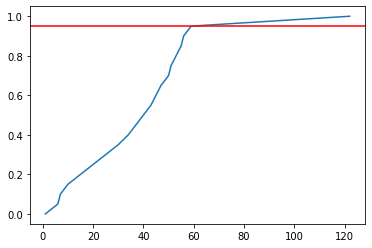

In [16]:
plt.plot(np.quantile(n_events_list, q, interpolation='midpoint'), q)
plt.axhline(q[-2], color='r')

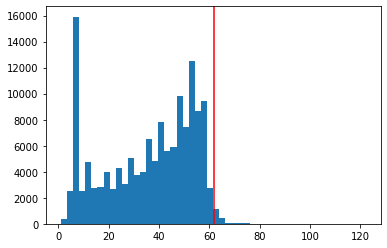

In [18]:
plt.hist(n_events_list, bins=50)
plt.axvline(62., color='r');

In [1]:
import torch
import vectorized_agents as va
import vectorized_env as ve
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ""
DEVICE = torch.device('cpu')

#va.run_vectorized_vs(va.RandomAgent(), va.RandomAgent(), n_envs=1000, env_device=DEVICE, out_device=DEVICE)

In [4]:
test_env = ve.KaggleMABEnvTorchVectorized(
    n_envs=1,
    n_players=2,
    n_bandits=5,
    obs_type=ve.LAST_60_EVENTS_OBS,
    env_device=DEVICE,
    out_device=DEVICE
)

for step in range(1000):
    actions = torch.randint(test_env.n_bandits-2, size=(test_env.n_envs, test_env.n_players))
    test_env.step(actions)

In [6]:
test_env.last_60_event_indices
#test_env.last_60_reward_events
#test_env.obs[:,:,:,:20].view(test_env.n_envs, test_env.n_players, test_env.n_bandits, -1, 4)

tensor([[59, 59, 59,  0,  0]])

In [38]:
%%timeit
pulls_one_hot = torch.sparse.FloatTensor(all_pull_indices, torch.ones(all_pull_indices.shape[1], dtype=torch.float, device=torch.device('cuda')), torch.Size([n_envs, n_players, n_bandits, n_steps]))
pulls_one_hot.to_dense()

16.7 ms ± 529 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
%%timeit

#envs_idxs = torch.arange(n_envs).repeat_interleave(n_players)
#players_idxs = torch.arange(n_players).repeat(n_envs)
player_n_pulls.view(-1, n_bandits).scatter_(-1, actions, player_n_pulls.view(-1, n_bandits).gather(-1, actions) + 1)
player_rewards_sums.view(-1, n_bandits).scatter_(-1, actions, player_rewards_sums.view(-1, n_bandits).gather(-1, actions) + pull_rewards.view(-1, 1))

player_n_pulls, player_rewards_sums

131 µs ± 119 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [65]:
from importlib import reload
import vectorized_agents as va
OBS_NORM = 100. / 1999.

reload(va)
va.run_vectorized_vs(
    va.RandomAgent(),
    va.RandomAgent(),
    #va.PullVegasSlotMachines(OBS_NORM),
    #va.PullVegasSlotMachines(OBS_NORM),
    #va.AlwaysFirstAgent(),
    #va.AlwaysFirstAgent(),
    #va.PullVegasSlotMachinesImproved(OBS_NORM),
    #va.BasicThompsonSampling(OBS_NORM),
    #va.BasicThompsonSampling(OBS_NORM),
    n_envs=600)

100%|██████████| 1999/1999 [00:19<00:00, 103.94it/s]


RandomAgent -vs- RandomAgent
Mean scores: 591.85 - 591.93
Match score: 291 - 7 - 302 (48.5% - 1.2% - 50.3%)


## Seeing output from replays_to_database

In [ ]:
from replays_to_database import load_s_a_r_d_s
import torch

s_batch, a_batch, r_batch, d_batch, next_s_batch = load_s_a_r_d_s(
    '/home/isaiah/GitHub/Kaggle/Santa_2020/episode_scraping/replays_database_TEMP/'
)

In [ ]:
idx = 200
torch.cat([s_batch[idx], next_s_batch[idx]], dim=-1)